# OCTDL Preprocessing

### Overview

This notebook is designed for preprocessing a OCTDL, which is a crucial step in preparing data for training machine learning models, particularly in medical imaging tasks. Preprocessing ensures that the input data is consistent in format, size, and type, which helps in achieving better performance and more reliable results from the models. Optical coherence tomography (OCT) is a non-invasive imaging technique with extensive clinical applications in ophthalmology. OCT enables the visualization of the retinal layers, playing a vital role in the early detection and monitoring of retinal diseases

### Objective

* Data Cleaning: To ensure the dataset only contains relevant and properly labeled images.

* Data Splitting: To divide the data into training, validation, and test sets based on patient IDs. This separation is important to avoid data leakage where information from the test set is known during training, potentially leading to overfitting and poor model generalization.

* Image Preprocessing: To standardize the images by resizing, cropping, and padding. This uniformity is crucial for the algorithm to learn effectively without bias from varying image sizes or scales.

### Dataset

 The dataset comprises 2064 images originating from 821 distinct patients. The dataset is meticulously organized, with each image accompanied by a detailed metadata record in a CSV file. This file encapsulates various attributes such as ‘file_name’, ‘disease’, ‘subcategory’, ‘condition’, ‘patient_id’, ‘eye’, ‘sex’, ‘year’, ‘image_width’, and ‘image_height’. Here, the ‘year’ attribute specifically denotes the year the image was taken, providing temporal context which could be relevant for longitudinal studies or tracking disease progression.

This dataset encapsulates a broad spectrum of seven disease classes, which include: 
* Age-related Macular Degeneration (AMD)
* Diabetic Macular Edema (DME)
* Epiretinal Membrane (ERM) 
* Retinal Artery Occlusion (RAO)
* Vitreoretinal Interface Disease (VID)
* Retinal Vein Occlusion (RVO)
* Normal (NO)

These classes form the basis for developing predictive models that aim to diagnose these conditions from the retinal images. The notebook's setup for preprocessing — including cleaning, splitting, and standardizing the images — is tailored to prepare this dataset for subsequent analysis and model training, ensuring that the data used in training, validation, and testing phases is representative, balanced, and adheres strictly to the required input format for deep learning models. 

In [4]:
#pip install opencv-python
import os
from os import listdir
from os.path import isfile
from os.path import join
from pathlib import Path
import cv2
from math import ceil
import argparse
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
df_labels = pd.read_csv('C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/OCTDL_labels.csv')
df_labels

,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1047099_1,AMD,intermediate,MNV_suspected,1047099,0,0,0,1101,410
1,amd_1047099_2,AMD,intermediate,MNV_suspected,1047099,0,0,0,731,265
2,amd_1047099_3,AMD,intermediate,MNV_suspected,1047099,0,0,0,1100,410
3,amd_1047099_4,AMD,intermediate,MNV_suspected,1047099,0,0,0,882,321
4,amd_1084498_1,AMD,late,MNV,1084498,0,0,0,882,321
...,...,...,...,...,...,...,...,...,...,...
2059,vid_9300009_2,VID,LH,MH,9300009,OS,F,1959,879,288
2060,vid_9412101_1,VID,MH,MH,9412101,0,0,0,913,288
2061,vid_9474645_1,VID,LH,MH,9474645,0,0,0,579,211
2062,vid_9474645_2,VID,LH,MH,9474645,0,0,0,579,210


In [7]:
# data understaning
df_labels = df_labels[df_labels['year'] != 0]
df_labels.reset_index(drop=True, inplace=True)
print(len(df_labels))
print(df_labels['disease'].value_counts())
df_labels.head(3)

448
disease
AMD    348
NO      48
ERM     22
VID     18
RVO      8
DME      4
Name: count, dtype: int64


,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1101816_1,AMD,late,MNV,1101816,OD,F,1941,882,322
1,amd_1101816_2,AMD,late,MNV,1101816,OD,F,1941,882,322
2,amd_1101816_3,AMD,late,MNV,1101816,OS,F,1941,882,322


In [8]:
# relabeling
df_labels = df_labels[(df_labels['disease'] != 'VID') & (df_labels['disease'] != 'RVO') & (df_labels['disease'] != 'DME')]
df_labels['disease'] = df_labels['disease'].apply(lambda x: 1 if x == 'AMD' else 0)
print(len(df_labels))
print(df_labels['disease'].value_counts())

418
disease
1    348
0     70
Name: count, dtype: int64


In [ ]:
dir = "C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL"
#Input 
dataset_folder = dir + "/OCTDL images/"
#lables for each Input
labels_path = dir + "/OCTDL_labels.csv"
#Output
output_folder = dir + "/output"
#Defines the ratio for central cropping of images; 1 means no cropping. default=1
crop_ratio = 1
#Specifies the dimensions to which images should be resized Default is 512
image_dim =512
#validation set
val_ratio = 0.15
#test_ratio
test_ratio = 0.25
#A boolean flag that, when true, indicates images should be padded to become square. Default is False
padding = True
#A boolean flag that, when true, indicates images should be cropped centrally according to the crop_ratio Default is False.
crop = False
#A boolean flag that, when true, indicates images should be resized to image_dim. Default is False.
resize =True

describing the directory and data cleaning parameters for preprocessing of the data

In [ ]:
labels = ['AMD', 'DME', 'ERM', 'NO', 'VID']
folders = ['train', 'val', 'test']

Classes and name of folders for cleaned data

In [ ]:
def padding(img):
    """Returns padded to square image
    """
    height = img.shape[0]
    width = img.shape[1]
    if width == height:
        return img
    elif width > height:
        left = 0
        right = 0
        bottom = ceil((width - height) / 2)
        top = ceil((width - height) / 2)
        result = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0)) #cv2.copyMakeBorder is used to apply this padding, where the new borders are filled with black color
        return result
    else:
        left = ceil((height - width) / 2)
        right = ceil((height - width) / 2)
        bottom = 0
        top = 0
        result = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        return result

takes an image (referred to as img) and adjusts it so that it becomes a square. It ensures that the width and height of the image are the same by adding black-colored borders where necessary.

* It first measures the height and width of the input image. If the width and height are the same, the function just returns the image as it is.

*  If the image has more width than height, it calculates how much padding is needed to make the image square and adds it equally to the top and bottom of the image.

* If the image has more height than width, it calculates the padding needed and adds it equally to the left and right sides of the image.

Note: cv2.copyMakeBorder is used to apply this padding, where the new borders are filled with black color

In [ ]:
def center_crop(img, dim):
    """Returns center cropped image
    """
    width, height = img.shape[1], img.shape[0]
    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2)
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

This takes an image and a dimensions of the image as input and returns a version of the image that has been cropped around the center to the specified dimensions. 

* It first determines the current width and height of the image by accessing the image’s shape.

*  Then checks the desired crop dimensions provided in dim. It then ensures these dimensions do not exceed the image’s actual size. If the desired dimensions are larger than the image, it keeps the orignal dimensions. 

* It calculates the center point of the image by dividing the width and height by two.

* To make sure the cropping is centered, it calculates half the width and half the height of the crop dimensions. This helps in determining the exact boundaries of the crop area.

* FInally it calculates where to start and stop the crop in both vertical and horizontal directions. It uses the center of the image as a reference point, and crops it

In [ ]:
def scale_image(img, factor=1):
    width = int(img.shape[1] * factor)
    height = int(img.shape[0] * factor)
    dsize = (width, height)
    output = cv2.resize(img, dsize, interpolation=cv2.INTER_LANCZOS4)
    return output

The function scale_image is designed to resize an image by a given scale factor, keeping the image's proportions the same. 

Note: cv2.INTER_LANCZOS4 is used for reducing or increasing image size while maintaining high image quality.

In [ ]:
def preprocessing(root_folder, output_folder, file, folder, crop_ratio, dim, label, padding_bool, crop_bool, resize_bool):
    img = cv2.imread(os.path.join(root_folder, label, file))
    if padding_bool:
        img = padding(img)
    if crop_bool:
        img = center_crop(img, (img.shape[1] * crop_ratio, img.shape[0] * crop_ratio))
    if resize_bool:
        img = cv2.resize(img, dim, interpolation=cv2.INTER_LANCZOS4)    #cv2.INTER_LANCZOS4 is used for reducing or increasing image size while maintaining high image quality.
    cv2.imwrite(os.path.join(output_folder, folder, label, Path(file).name), img, [cv2.IMWRITE_JPEG_QUALITY, 100])  #image is saved with high JPEG quality (100), which means minimal compression and maximal quality.

Calls the functions for resizing, cropping and padding, based on the padding_bool, crop_bool and resize_bool. Then saves the images in output folder -> file_name( train, test, and val) -> disease class -> image name

In [ ]:
root_folder = dataset_folder
train_ratio = 1 - val_ratio - test_ratio
dim = (image_dim, image_dim)
padding_bool = padding
crop_bool = crop
resize_bool = resize
#Reading the Labels
df = pd.read_csv(labels_path)
df= df[df['sex'] != '0']

image_ids = set(df['file_name'])
base_directory = dir +  '/OCTDL images/'
diseases = df['disease'].unique()

for disease in diseases:
    disease_folder_path = os.path.join(dataset_folder, disease)
    
    if not os.path.exists(disease_folder_path):
        print(f"Folder not found: {disease_folder_path}")
        continue
    
    files = os.listdir(disease_folder_path)
    
    for file in files:
        if file.split('.')[0] not in image_ids:
            file_path = os.path.join(disease_folder_path, file)
            os.remove(file_path)
            print(f"Deleted {file_path}")

class_dist = df[['disease','patient_id']].groupby('disease')['patient_id'].nunique().reset_index(name='Patient count')
total_unique_patients = class_dist['Patient count'].sum()
class_dist['Percentage Of Total'] = ((class_dist['Patient count'] / total_unique_patients) * 100).round(2)
class_dist

,disease,Patient count,Percentage Of Total
0,AMD,148,78.72
1,DME,1,0.53
2,ERM,12,6.38
3,NO,16,8.51
4,RVO,4,2.13
5,VID,7,3.72


we focus on ensuring that only images associated with patients who have valid sex  are retained. This preprocessing is crucial in the context of analyzing and comparing the performance of two types of neural networks: Convolutional Neural Networks (CNN) and Confounder Free Neural Networks (CF-NET), with sex as confounding variables.

In [ ]:
for folder in folders:
    for label in labels:
        Path(os.path.join(output_folder, folder, label)).mkdir(parents=True, exist_ok=True)

Creates the output folder

In [ ]:
for label in tqdm(labels):
        df_label = df[df['disease'] == label][['file_name', 'disease', 'patient_id']]
        patients_list = df_label.patient_id.unique()
        if len(patients_list) < 10:
            print(f"Skipping {label} due to insufficient data.")
            continue
        train_patients, test_patients = train_test_split(patients_list, test_size=1 - train_ratio)
        val_patients, test_patients = train_test_split(test_patients, test_size=test_ratio / (test_ratio + val_ratio))
        df_label_train = df_label[df_label['patient_id'].isin(train_patients)]
        df_label_val = df_label[df_label['patient_id'].isin(val_patients)]
        df_label_test = df_label[df_label['patient_id'].isin(test_patients)]
        
        print(label, len(df_label_train), len(df_label_val), len(df_label_test))

100%|██████████| 5/5 [00:00<00:00, 624.47it/s]

AMD 206 57 85
Skipping DME due to insufficient data.
ERM 13 1 8
NO 28 4 16
Skipping VID due to insufficient data.


Divides the dataset into training, validation, and test subsets based on patient data for different disease classes.

* It loops through each unique disease class stored in labels. The progress of this loop is tracked using tqdm, (displays a progress bar).
* For each disease class, it selects image names, classes, and patient IDs from df that match the current label.
* The code identifies unique patient IDs associated with each label. If a disease class has fewer than 10 unique patients
* It splits the list of patient IDs into training validation, and test groups based on a ratio 
* Creates 3 new df for each train, test and val dataset

In [ ]:
for i in range(0, len(df_label_train)):
    file_name = df_label_train.iloc[i, 0] + '.jpg'
    file_label = df_label_train.iloc[i, 1]    
    preprocessing(root_folder, output_folder, file_name, 'train', crop_ratio, dim, file_label, padding_bool, crop_bool, resize_bool)

for i in range(0, len(df_label_test)):
    file_name = df_label_test.iloc[i, 0] + '.jpg'
    file_label = df_label_test.iloc[i, 1]    
    preprocessing(root_folder, output_folder, file_name, 'test', crop_ratio, dim, file_label, padding_bool, crop_bool, resize_bool)    

for i in range(0, len(df_label_val)):
    file_name = df_label_val.iloc[i, 0] + '.jpg'
    file_label = df_label_val.iloc[i, 1]    
    preprocessing(root_folder, output_folder, file_name, 'val', crop_ratio, dim, file_label, padding_bool, crop_bool, resize_bool) 

Executes the function preprocessing for each df(train, validation, and test) which in-turn calls the functions for resizing, cropping and padding.

In [ ]:
df_labels = pd.read_csv('C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/OCTDL_labels.csv')
df_labels

In [ ]:
# data understaning
df_labels = df_labels[df_labels['year'] != 0]
df_labels.reset_index(drop=True, inplace=True)
print(len(df_labels))
print(df_labels['disease'].value_counts())
df_label.head(3)

In [ ]:
# relabeling
df_labels['disease'] = df_labels['disease'].apply(lambda x: 1 if x == 'AMD' else 0)
print(len(df_labels))
print(df_labels['disease'].value_counts())

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your image file
image_path = os.path.join(image_directory, df_labels['file_name'][1] + ".jpg")

# Load the image using Matplotlib
image = mpimg.imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# replacing the names with paths
df_labels['file_name'] = df_labels['file_name'].apply(lambda x:os.path.join(image_directory, x + ".jpg"))
df_labels['file_name'].head(3)

In [9]:
import os
import shutil

# Source directory containing folders and subfolders with files
source_directory = "C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/output"

# Destination directory to save all files
destination_directory = "C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/output-2"

# Walk through the directory tree and copy files
for root, dirs, files in os.walk(source_directory):
    for file in files:
        # Construct the source and destination paths
        source_path = os.path.join(root, file)
        relative_path = os.path.relpath(root, source_directory)  # Relative path from source directory
        destination_path = os.path.join(destination_directory, file)
        
        # Create directories in the destination if they don't exist
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        
        # Copy the file to the destination directory
        shutil.copyfile(source_path, destination_path)

print("Files copied successfully.")

Files copied successfully.


In [10]:
image_names = df_labels['file_name']

# Directory where your images are stored
image_directory = "C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/output-2"

# List to store missing image names
missing_images = []

# Check if each image file exists in the directory
for image_name in image_names:
    image_path = os.path.join(image_directory, image_name + ".jpg")  # assuming jpg extension
    if not os.path.exists(image_path):
        # If the image file doesn't exist, add its name to the list of missing images
        missing_images.append(image_name)

# Print missing images
if missing_images:
    print("The following images are missing:")
    for image_name in missing_images:
        print(image_name)
else:
    print("All images are available in the directory.")

All images are available in the directory.


In [11]:
df_labels

,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1101816_1,1,late,MNV,1101816,OD,F,1941,882,322
1,amd_1101816_2,1,late,MNV,1101816,OD,F,1941,882,322
2,amd_1101816_3,1,late,MNV,1101816,OS,F,1941,882,322
3,amd_1101816_4,1,late,MNV,1101816,OS,F,1941,882,322
4,amd_1191668_1,1,intermediate,MNV_suspected,1191668,OD,F,1948,882,322
...,...,...,...,...,...,...,...,...,...,...
417,no_9054704_2,0,emmetropia,NO,9054704,OD,M,1955,882,318
418,no_9317962_1,0,emmetropia,NO,9317962,OD,F,1947,882,322
419,no_9317962_2,0,emmetropia,NO,9317962,OS,F,1947,882,314
420,no_9663705_1,0,emmetropia,NO,9663705,OD,F,1952,914,291


In [12]:
#  checking gray scale
from PIL import Image

def is_grayscale(image_path):
    """
    Check if the image at the given path is grayscale or not.
    
    Args:
    image_path (str): Path to the image file.
    
    Returns:
    bool: True if the image is grayscale, False otherwise.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Convert the image to grayscale (L mode) and compare with the original
    return img.convert('L').mode == 'L'

# Example usage
image_path = os.path.join(image_directory, df_labels['file_name'][0] + ".jpg")
if is_grayscale(image_path):
    print("The image is grayscale.")
else:
    print("The image is not grayscale.")

The image is grayscale.


In [13]:
import numpy as np

# checking dimensions

def image_dimensions(image_path):
    """
    Check if the image at the given path is 2D or 3D.
    
    Args:
    image_path (str): Path to the image file.
    
    Returns:
    str: '2D' if the image is grayscale, '3D' if the image is color.
    """
    # Load the image using a library like Pillow or OpenCV
    # Assuming you're using PIL (Pillow)
    from PIL import Image
    
    img = Image.open(image_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check the number of dimensions
    if len(img_array.shape) == 2:
        return '2D'  # Grayscale image
    elif len(img_array.shape) == 3:
        return '3D'  # Color image
    else:
        return 'Unknown'

# Example usage
image_path = os.path.join(image_directory, df_labels['file_name'][0] + ".jpg")
image_type = image_dimensions(image_path)
print("Image type:", image_type)

Image type: 3D


In [14]:
def is_grayscale(image_path):
    """
    Check if the image at the given path is grayscale or not.
    
    Args:
    image_path (str): Path to the image file.
    
    Returns:
    bool: True if the image is grayscale, False otherwise.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Convert the image to a NumPy array
    img_array = np.array(img)
    
    # Check if the image has only one channel
    return len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1)


In [15]:
print(is_grayscale(image_path))

False


In [16]:
df_labels

,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight
0,amd_1101816_1,1,late,MNV,1101816,OD,F,1941,882,322
1,amd_1101816_2,1,late,MNV,1101816,OD,F,1941,882,322
2,amd_1101816_3,1,late,MNV,1101816,OS,F,1941,882,322
3,amd_1101816_4,1,late,MNV,1101816,OS,F,1941,882,322
4,amd_1191668_1,1,intermediate,MNV_suspected,1191668,OD,F,1948,882,322
...,...,...,...,...,...,...,...,...,...,...
417,no_9054704_2,0,emmetropia,NO,9054704,OD,M,1955,882,318
418,no_9317962_1,0,emmetropia,NO,9317962,OD,F,1947,882,322
419,no_9317962_2,0,emmetropia,NO,9317962,OS,F,1947,882,314
420,no_9663705_1,0,emmetropia,NO,9663705,OD,F,1952,914,291


In [19]:
df_labels['file_path'] = df_labels['file_name'].apply(lambda x: os.path.join(image_directory, x + ".jpg"))

In [21]:
df_labels['file_path'][0]

'C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/OCTDL/output-2\\amd_1101816_1.jpg'

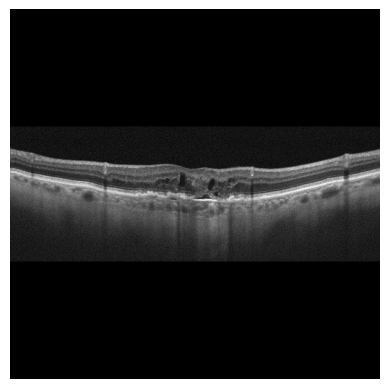

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image using Matplotlib
image = mpimg.imread(df_labels['file_path'][0])

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [24]:
df_labels.to_csv('df_labels.csv')